In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train.csv')
test = pd.read_csv('../data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

df = pd.concat([train, val, test], axis=0).reset_index(drop=True)

train_idx = df.iloc[:len(train), :].index
val_idx = df.iloc[len(train):len(train)+len(val), :].index
test_idx = df.iloc[len(train)+len(val):, :].index

train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


# torch gpu

In [4]:
import sys
PATH_TO_REPO = "/home/bis/2021_AIhub/esm/"
sys.path.append(PATH_TO_REPO)

import torch
import esm

from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook
import time
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW
# from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import WarmupLinearSchedule as get_linear_schedule_with_warmup

import torch.nn.functional as F

In [5]:
##GPU 사용 시
device = torch.device("cuda")

In [6]:
esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()

In [7]:
ct = 0
for child in esm_model.children():
    ct += 1
#     print(ct, child)
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [8]:
class ESMDataset(Dataset):
    def __init__(self, datasets, idxes):
        pep_idx, nterm_idx, cterm_idx, m1term_idx, m2term_idx, label_idx = idxes
        pep_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, pep_idx])]
        nterm_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, nterm_idx])]
        cterm_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, cterm_idx])]
        m1_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, m1term_idx])]
        m2_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, m2term_idx])]
        
        labels, pep_strs, pep_tokens = batch_converter(pep_data)
        _, n_strs, n_tokens = batch_converter(nterm_data)
        _, c_strs, c_tokens = batch_converter(cterm_data)
        _, m1_strs, m1_tokens = batch_converter(m1_data)
        _, m2_strs, m2_tokens = batch_converter(m2_data)

        self.sentences = [pep_tokens, n_tokens, c_tokens, m1_tokens, m2_tokens]
        self.labels = labels

    def __getitem__(self, i):
        return (
                (self.sentences[0][i], ) + (self.sentences[1][i],) \
                + (self.sentences[2][i], ) + (self.sentences[3][i], ) + (self.sentences[4][i], ) \
                + (self.labels[i], )
               )

    def __len__(self):
        return (len(self.labels))

# [PAD] = 1, [MASK] = 21  [CLS] = 0 (special classification token), [SEP] = 2 (seperate segment), Z = 27, '-' = 30, .=29, ,=28
# J 없음
# A 2, B 25, C 23, D 13, E 9, F 18, G 6, H 21, I 12, K 15, L 4, M 20, N 17, 
# O 28, P 14, Q 16, R 10, S 8, T 11, U 26, V 7, W 22, X 24, Y 19, Z 27
# 3 5 없음

In [9]:
## Setting parameters
max_len = 30
batch_size = 256
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  1e-4

In [10]:
s = time.time()

dataset_train = train[['PEP', 'En', 'Ec', 'E1', 'E2', 'ID']].values
dataset_valid = val[['PEP', 'En', 'Ec', 'E1', 'E2', 'ID']].values
dataset_test = test[['PEP', 'En', 'Ec', 'E1', 'E2', 'ID']].values

data_train = ESMDataset(dataset_train, [0, 1, 2, 3, 4, 5])
data_valid = ESMDataset(dataset_valid, [0, 1, 2, 3, 4, 5])

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=48)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=48)

e = time.time()
print(round(e-s, 2),'sec')

474.93 sec


In [19]:
data_test = ESMDataset(dataset_test, [0, 1, 2, 3, 4, 5])
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=48)

# model

In [11]:
class ESMClassifier(nn.Module):
    def __init__(self,
                 esm,
                 num_classes=1,
                 params=None):
        
        super(ESMClassifier, self).__init__()
        self.esm = esm
        self.pep_lstm1 = nn.LSTM(input_size=1280, hidden_size=512, batch_first=True)
        self.pep_drop1 = nn.Dropout(p=0.2)
        self.pep_lstm2 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True)
        self.pep_drop2 = nn.Dropout(p=0.2)
        self.pep_lstm3 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        self.pep_drop3 = nn.Dropout(p=0.2)
        
        self.ts_lstm1 = nn.LSTM(input_size=1280, hidden_size=512, batch_first=True)
        self.ts_drop1 = nn.Dropout(p=0.2)
        self.ts_lstm2 = nn.LSTM(input_size=512, hidden_size=128, batch_first=True)
        self.ts_drop2 = nn.Dropout(p=0.2)
        self.ts_lstm3 = nn.LSTM(input_size=128, hidden_size=64,  batch_first=True)
        self.ts_drop3 = nn.Dropout(p=0.2)
                
        self.fc1 = nn.Linear(384, 256)
        self.fc_drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 128)
        self.fc_drop2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, 1)


#     def gen_attention_mask(self, token_ids, valid_length):
#         attention_mask = torch.zeros_like(token_ids)
#         for i, v in enumerate(valid_length):
#             attention_mask[i][:v] = 1
#         return attention_mask.float()

    def forward(self, token_ids, en_token_ids, ec_token_ids, e1_token_ids, e2_token_ids):
#         attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        pep_embed = self.esm(token_ids, repr_layers=[33])['representations'][33]
        pep_lstm, (pep_hn, __) = self.pep_lstm1(pep_embed)
        pep_hn = self.pep_drop1(pep_hn)
        pep_lstm, (_, __) = self.pep_lstm2(pep_lstm)
        pep_lstm = self.pep_drop2(pep_lstm)
        _, (pep_hn, __) = self.pep_lstm3(pep_lstm)
        pep_hn = self.pep_drop3(pep_hn)
        
        en_embed = self.esm(en_token_ids, repr_layers=[33])['representations'][33]
        ec_embed = self.esm(ec_token_ids, repr_layers=[33])['representations'][33]
        e1_embed = self.esm(e1_token_ids, repr_layers=[33])['representations'][33]
        e2_embed = self.esm(e2_token_ids, repr_layers=[33])['representations'][33]
        
        en_lstm, (_, __) = self.ts_lstm1(en_embed)
        en_lstm = self.ts_drop1(en_lstm)
        en_lstm, (_, __) = self.ts_lstm2(en_lstm)
        en_lstm = self.ts_drop2(en_lstm)
        _, (en_hn, __) = self.ts_lstm3(en_lstm)
        en_hn = self.ts_drop3(en_hn)
        
        ec_lstm, (_, __) = self.ts_lstm1(ec_embed)
        ec_lstm = self.ts_drop1(ec_lstm)
        ec_lstm, (_, __) = self.ts_lstm2(ec_lstm)
        ec_lstm = self.ts_drop2(ec_lstm)
        _, (ec_hn, __) = self.ts_lstm3(ec_lstm)
        ec_hn = self.ts_drop3(ec_hn)
        
        e1_lstm, (_, __) = self.ts_lstm1(e1_embed)
        e1_lstm = self.ts_drop1(e1_lstm)
        e1_lstm, (_, __) = self.ts_lstm2(e1_lstm)
        e1_lstm = self.ts_drop2(e1_lstm)
        _, (e1_hn, __) = self.ts_lstm3(e1_lstm)
        e1_hn = self.ts_drop3(e1_hn)
        
        e2_lstm, (_, __) = self.ts_lstm1(e2_embed)
        e2_lstm = self.ts_drop1(e2_lstm)
        e2_lstm, (_, __) = self.ts_lstm2(e2_lstm)
        e2_lstm = self.ts_drop2(e2_lstm)
        _, (e2_hn, __) = self.ts_lstm3(e2_lstm)
        e2_hn = self.ts_drop3(e2_hn)
        
        merge = torch.cat([pep_hn[0], en_hn[0], ec_hn[0], e1_hn[0], e2_hn[0]], dim=1)

        merge = self.fc1(merge)
        merge = self.fc_drop1(merge)
        merge = self.fc2(merge)
        merge = self.fc_drop2(merge)
        merge = self.fc3(merge)
        
        out = torch.sigmoid(merge)
        return out

In [12]:
model = ESMClassifier(esm_model).to(device)

In [13]:
model.eval()

ESMClassifier(
  (esm): ProteinBertModel(
    (embed_tokens): Embedding(33, 1280, padding_idx=1)
    (layers): ModuleList(
      (0): TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      )
      (1): TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_fe

In [14]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-------------------------------+------------+
|            Modules            | Parameters |
+-------------------------------+------------+
|        esm.lm_head.bias       |     33     |
|    esm.lm_head.dense.weight   |  1638400   |
|     esm.lm_head.dense.bias    |    1280    |
| esm.lm_head.layer_norm.weight |    1280    |
|  esm.lm_head.layer_norm.bias  |    1280    |
|     pep_lstm1.weight_ih_l0    |  2621440   |
|     pep_lstm1.weight_hh_l0    |  1048576   |
|      pep_lstm1.bias_ih_l0     |    2048    |
|      pep_lstm1.bias_hh_l0     |    2048    |
|     pep_lstm2.weight_ih_l0    |   524288   |
|     pep_lstm2.weight_hh_l0    |   262144   |
|      pep_lstm2.bias_ih_l0     |    1024    |
|      pep_lstm2.bias_hh_l0     |    1024    |
|     pep_lstm3.weight_ih_l0    |   131072   |
|     pep_lstm3.weight_hh_l0    |   65536    |
|      pep_lstm3.bias_ih_l0     |    512     |
|      pep_lstm3.bias_hh_l0     |    512     |
|     ts_lstm1.weight_ih_l0     |  2621440   |
|     ts_lstm

10486562

In [15]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()
# loss_fn = F.binary_cross_entropy()

t_total = len(train_dataloader) * num_epochs
# warmup_step = int(t_total * warmup_ratio)

# scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps=warmup_step, t_total=t_total)

def calc_accuracy(X,Y):
    train_acc = ((X>0.5)==Y).sum().data.cpu().numpy() / len(Y)
    return train_acc

In [16]:
best_acc = 0
for e in range(num_epochs):
    t0=time.time()
    train_acc = 0.0
    test_acc = 0.0
    
    model.train()
    for batch_id, (pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids, label) in enumerate(train_dataloader):
#         print(batch_id, round(time.time()-t0,2))
        
        pep_token_ids = pep_token_ids.long().to(device)
        n_token_ids = n_token_ids.long().to(device)
        c_token_ids = c_token_ids.long().to(device)
        m1_token_ids = m1_token_ids.long().to(device)
        m2_token_ids = m2_token_ids.long().to(device)
        label = torch.reshape(label.float(), (-1, 1)).to(device)
        
        pred = model(pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids)
        loss = F.binary_cross_entropy(pred, label)
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += calc_accuracy(pred, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {} time {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1), round(time.time()-t0, 2)))
        
    print("epoch {} train acc {} time {}".format(e+1, train_acc / (batch_id+1), round(time.time()-t0,2)))
    
    model.eval()
    for batch_id, (pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids, label) in enumerate(valid_dataloader):
        pep_token_ids = pep_token_ids.long().to(device)
        n_token_ids = n_token_ids.long().to(device)
        c_token_ids = c_token_ids.long().to(device)
        m1_token_ids = m1_token_ids.long().to(device)
        m2_token_ids = m2_token_ids.long().to(device)
        label = label.long().to(device)
        label = torch.reshape(label, (-1, 1))
        pred = model(pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids)
        
        test_acc += calc_accuracy(pred, label)
    if (test_acc / (batch_id+1)) > best_acc:
        best_acc=test_acc
        torch.save({"best_acc":best_acc / (batch_id+1),"model":model.state_dict()},f'./highParam/high.pl')
        print(f"best_acc: {best_acc}")
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

epoch 1 batch id 1 loss 0.6928390264511108 train acc 0.5078125 time 17.11
epoch 1 batch id 201 loss 0.49028047919273376 train acc 0.7259600435323383 time 2979.81
epoch 1 batch id 401 loss 0.493201345205307 train acc 0.7393722724438903 time 5946.12
epoch 1 batch id 601 loss 0.4335503578186035 train acc 0.753028806156406 time 8916.09
epoch 1 batch id 801 loss 0.47761186957359314 train acc 0.76359140917603 time 11883.25
epoch 1 batch id 1001 loss 0.44172394275665283 train acc 0.7701946491008991 time 14837.89
epoch 1 batch id 1201 loss 0.4154757857322693 train acc 0.7765956754787677 time 17831.74
epoch 1 batch id 1401 loss 0.4932558238506317 train acc 0.7818661893290507 time 20926.19
epoch 1 batch id 1601 loss 0.44332221150398254 train acc 0.7860297275140538 time 24021.96
epoch 1 batch id 1801 loss 0.43403589725494385 train acc 0.7894290498334259 time 27117.55
epoch 1 batch id 2001 loss 0.40549710392951965 train acc 0.7920336706646677 time 30215.09
epoch 1 train acc 0.7936641928134248 time

epoch 8 batch id 1801 loss 0.3108729124069214 train acc 0.8571865456690727 time 25346.05
epoch 8 batch id 2001 loss 0.3131878077983856 train acc 0.8571417416291854 time 27543.68
epoch 8 train acc 0.8575264410142588 time 28885.71
epoch 8 test acc 0.826023422787194
epoch 9 batch id 1 loss 0.2986278831958771 train acc 0.8671875 time 13.98
epoch 9 batch id 201 loss 0.29229071736335754 train acc 0.8611823694029851 time 2210.9
epoch 9 batch id 401 loss 0.3056081235408783 train acc 0.8602906795511222 time 4407.32
epoch 9 batch id 601 loss 0.3218837380409241 train acc 0.8606619176372712 time 6603.61
epoch 9 batch id 801 loss 0.39903324842453003 train acc 0.8620962078651685 time 8799.59
epoch 9 batch id 1001 loss 0.32957977056503296 train acc 0.8614042207792207 time 10996.21
epoch 9 batch id 1201 loss 0.31590208411216736 train acc 0.8616875260199833 time 13193.14
epoch 9 batch id 1401 loss 0.35987457633018494 train acc 0.8620990587080657 time 15390.43
epoch 9 batch id 1601 loss 0.30685350298881

In [21]:
torch.cuda.empty_cache()

In [22]:
pred = []
model.eval()
with torch.no_grad():
    for batch_id, (pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids, label) in enumerate(test_dataloader):
        pep_token_ids = pep_token_ids.long().to(device)
        n_token_ids = n_token_ids.long().to(device)
        c_token_ids = c_token_ids.long().to(device)
        m1_token_ids = m1_token_ids.long().to(device)
        m2_token_ids = m2_token_ids.long().to(device)
        label = label.long().to(device)
        label = torch.reshape(label, (-1, 1))

        pred_batch = model(pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids)
        pred += list(pred_batch)
        test_acc += calc_accuracy(pred_batch, label)

In [32]:
y_test = test.ID.values

In [34]:
y_pred = [1 if _ >= 0.5 else 0 for _ in pred]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     66996
           1       0.82      0.85      0.83     66996

    accuracy                           0.83    133992
   macro avg       0.83      0.83      0.83    133992
weighted avg       0.83      0.83      0.83    133992



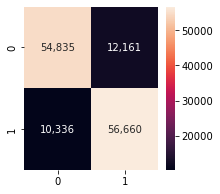

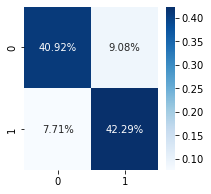

In [35]:
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [43]:
print('accuracy:', sum(np.array(y_pred)==y_test)/ len (y_pred))

accuracy: 0.8321019165323303


rf auc : 0.9069939676441866


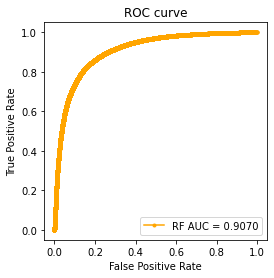

In [45]:
# AUC
probs = [_.cpu().numpy() for _ in pred]
rf_auc = roc_auc_score(y_test, probs)


print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [46]:
torch.save({"model":model.state_dict()}, f'./highParam/high2.pl')

In [ ]:
# # 학습에 사용할 CPU나 GPU 장치를 얻습니다.
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using {} device".format(device))

# # 모델을 정의합니다.
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10),
#             nn.ReLU()
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

# model = NeuralNetwork().to(device)
# print(model)

# def train(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     for batch, (X, y) in enumerate(dataloader):
#         X, y = X.to(device), y.to(device)

#         # 예측 오류 계산
#         pred = model(X)
#         loss = loss_fn(pred, y)

#         # 역전파
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     test_loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device), y.to(device)
#             pred = model(X)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# epochs = 5
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_dataloader, model, loss_fn, optimizer)
#     test(test_dataloader, model, loss_fn)
# print("Done!")